In [1]:
import os
import glob
import torch
import pandas as pd
import numpy as np
from pathlib import Path

# add code directory to path
import sys
sys.path.append('/cluster/home/kheuto01/code/prob_diff_topk')

from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from functools import partial
from torch_models import NegativeBinomialRegressionModel
from metrics import top_k_onehot_indicator
from torch_perturb.perturbations import perturbed
from torch_models import torch_bpr_uncurried, deterministic_bpr
from matplotlib import pyplot as plt

def load_data(data_dir):
    """Load and process training, validation, and test data."""
    # Load data
    train_X_df = pd.read_csv(os.path.join(data_dir, 'train_x.csv'), index_col=[0,1])
    train_Y_df = pd.read_csv(os.path.join(data_dir, 'train_y.csv'), index_col=[0,1])
    val_X_df = pd.read_csv(os.path.join(data_dir, 'valid_x.csv'), index_col=[0,1])
    val_Y_df = pd.read_csv(os.path.join(data_dir, 'valid_y.csv'), index_col=[0,1])
    test_X_df = pd.read_csv(os.path.join(data_dir, 'test_x.csv'), index_col=[0,1])
    test_Y_df = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), index_col=[0,1])
    
    def convert_df_to_3d_array(df):
        geoids = sorted(df.index.get_level_values('geoid').unique())
        timesteps = sorted(df.index.get_level_values('timestep').unique())
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        num_features = len(df.columns)
        X = np.zeros((num_timesteps, num_locations, num_features))
        
        for (geoid, timestep), row in df.iterrows():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            X[t_idx, g_idx, :] = row.values
            
        return X, geoids, timesteps

    def convert_y_df_to_2d_array(y_df, geoids, timesteps):
        num_timesteps = len(timesteps)
        num_locations = len(geoids)
        y = np.zeros((num_timesteps, num_locations))
        geoid_to_idx = {geoid: idx for idx, geoid in enumerate(geoids)}
        
        for (geoid, timestep), value in y_df.iloc[:, 0].items():
            t_idx = timesteps.index(timestep)
            g_idx = geoid_to_idx[geoid]
            y[t_idx, g_idx] = value
            
        return y

    # Process training data
    train_X, geoids, timesteps = convert_df_to_3d_array(train_X_df.drop(columns='timestep.1'))
    train_time = np.array([timesteps] * len(geoids)).T
    train_y = convert_y_df_to_2d_array(train_Y_df, geoids, timesteps)

    # Process validation data
    val_X, val_geoids, val_timesteps = convert_df_to_3d_array(val_X_df.drop(columns='timestep.1'))
    val_time = np.array([val_timesteps] * len(val_geoids)).T
    val_y = convert_y_df_to_2d_array(val_Y_df, val_geoids, val_timesteps)

    # Process test data
    test_X, test_geoids, test_timesteps = convert_df_to_3d_array(test_X_df.drop(columns='timestep.1'))
    test_time = np.array([test_timesteps] * len(test_geoids)).T
    test_y = convert_y_df_to_2d_array(test_Y_df, test_geoids, test_timesteps)

    return {
        'train': (torch.tensor(train_X, dtype=torch.float32), 
                 torch.tensor(train_time, dtype=torch.float32),
                 torch.tensor(train_y, dtype=torch.float32)),
        'val': (torch.tensor(val_X, dtype=torch.float32),
               torch.tensor(val_time, dtype=torch.float32),
               torch.tensor(val_y, dtype=torch.float32)),
        'test': (torch.tensor(test_X, dtype=torch.float32),
                torch.tensor(test_time, dtype=torch.float32),
                torch.tensor(test_y, dtype=torch.float32))
    }

def evaluate_model(model, X, time_T, y, K, perturbed_noise=0.01, num_pert_samples=50, num_score_samples=20):
    """Evaluate model using the same metrics as in training."""
    with torch.no_grad():
        dist = model(X, time_T)
        
        # Get samples for ratio calculation
        y_sample_TMS = dist.sample((num_score_samples,)).permute(1, 0, 2)
        ratio_rating_TMS = y_sample_TMS/y_sample_TMS.sum(dim=-1, keepdim=True)
        ratio_rating_TS = ratio_rating_TMS.mean(dim=1)
        
        # Calculate deterministic BPR
        det_bpr = deterministic_bpr(ratio_rating_TS, y, K=K)
        det_bpr = torch.mean(det_bpr)
        
        # Calculate perturbed BPR
        top_k_func = partial(top_k_onehot_indicator, k=K)
        perturbed_top_K_func = perturbed(top_k_func, sigma=perturbed_noise, num_samples=num_pert_samples)
        pert_bpr = torch_bpr_uncurried(ratio_rating_TS, y, K=K, perturbed_top_K_func=perturbed_top_K_func)
        pert_bpr = torch.mean(pert_bpr)
        
        # Calculate NLL
        nll = -model.log_likelihood(y, X, time_T)
        
        return {
            'det_bpr': det_bpr.item(),
            'pert_bpr': pert_bpr.item(),
            'nll': nll.item()
        }

def find_best_model_and_evaluate(base_dir, data_dir, device='cuda', K=100):
    """Find the best model based on validation performance and evaluate on test set."""
    # Load all data
    data = load_data(data_dir)
    
    # Move data to device
    val_data = tuple(x.to(device) for x in data['val'])
    test_data = tuple(x.to(device) for x in data['test'])
    # Find all experiment directories
    exp_dirs = glob.glob(os.path.join(base_dir, "K*"))
    
    best_val_score = float('-inf')
    best_model_info = None
    
    results = []
    print(exp_dirs)
    for exp_dir in exp_dirs:
        # Extract hyperparameters from directory name
        dir_name = os.path.basename(exp_dir)
        params = [param.split('_') for param in dir_name.split('_')]
        
        # Load model
        model_path = os.path.join(exp_dir, 'best_model.pth')
        if not os.path.exists(model_path):
            continue
            
        # Initialize model with correct parameters
        model = NegativeBinomialRegressionModel(
            num_locations=data['train'][0].shape[1],
            num_fixed_effects=data['train'][0].shape[2]
        ).to(device)
        
        
        # Load saved weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        
        # Evaluate on validation set
        val_performance = evaluate_model(
            model, *val_data, K=K,
        )
        
        # Track results
        result = {
            'dir': exp_dir,
            **val_performance,
            'params':params}

        results.append(result)
        
        # Update best model if this one is better
        if val_performance['det_bpr'] > best_val_score:
            best_val_score = val_performance['det_bpr']
            best_model_info = {
                'model': model,
                'dir': exp_dir,
                'params': params,
                'val_performance': val_performance
            }
        
        results.append(result)
    
    # Create results DataFrame
    results_df = pd.DataFrame(results)
    
    # Evaluate best model on test set
    if best_model_info is not None:
        test_performance = evaluate_model(
            best_model_info['model'], *test_data, K=K,
        )
        
        print("\nBest Model Information:")
        print(f"Directory: {best_model_info['dir']}")
        print(f"Parameters: {best_model_info['params']}")
        print("\nValidation Performance:")
        print(f"Deterministic BPR: {best_model_info['val_performance']['det_bpr']:.4f}")
        print(f"Perturbed BPR: {best_model_info['val_performance']['pert_bpr']:.4f}")
        print(f"NLL: {best_model_info['val_performance']['nll']:.4f}")
        print("\nTest Performance:")
        print(f"Deterministic BPR: {test_performance['det_bpr']:.4f}")
        print(f"Perturbed BPR: {test_performance['pert_bpr']:.4f}")
        print(f"NLL: {test_performance['nll']:.4f}")
    
    return results_df, best_model_info

2025-01-13 12:40:24.202893: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 12:40:24.552695: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 12:40:24.552734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 12:40:24.559265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 12:40:24.574424: I tensorflow/core/platform/cpu_feature_guar

In [8]:
data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/cleaned/MA'
base_dir = '/cluster/tufts/hugheslab/kheuto01/opioid_hpc_test_long/MA/'

In [9]:

def make_negative_binomial_report(exp_dir, title=None):
    """
    Generate a report with training metrics from saved CSV files.
    
    Args:
        exp_dir: Directory containing experiment metrics files
        title: Title for the report
    """
    # Load metrics from CSV files
    train_metrics = pd.read_csv(os.path.join(exp_dir, 'train_metrics.csv'), index_col='epochs')
    val_metrics = pd.read_csv(os.path.join(exp_dir, 'val_metrics.csv'), index_col='epochs')
    times = pd.read_csv(os.path.join(exp_dir, 'time_metrics.csv'))


    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    if title:
        fig.suptitle(title, fontsize=16)
    else:
        fig.suptitle(os.path.basename(exp_dir), fontsize=16)

    # Plot training and validation metrics
    epochs = train_metrics.index
    
    # Loss plot
    axes[0, 0].plot(epochs, train_metrics['loss'], 'b-', label='Train Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    axes[0, 0].legend()
    
    # BPR plot
    axes[0, 1].plot(epochs, train_metrics['deterministic_bpr'], 'g-', label='Train BPR')
    if 'deterministic_bpr' in val_metrics.columns:
        val_epochs = val_metrics.index
        axes[0, 1].plot(val_epochs, val_metrics['deterministic_bpr'], 'g--', label='Val BPR')
    axes[0, 1].set_title('Deterministic BPR')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('BPR')
    axes[0, 1].grid(True)
    axes[0, 1].legend()
    
    # NLL plot
    axes[1, 0].plot(epochs, train_metrics['nll'], 'r-', label='Train NLL')
    if 'nll' in val_metrics.columns:
        axes[1, 0].plot(val_epochs, val_metrics['nll'], 'r--', label='Val NLL')
    axes[1, 0].set_title('Negative Log Likelihood (NLL)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('NLL')
    axes[1, 0].grid(True)
    axes[1, 0].legend()

    # Time plot
    cumulative_time = np.cumsum(times['times'])
    axes[1, 1].plot(np.arange(len(cumulative_time)), cumulative_time, 'm-', label='Cumulative Time')
    axes[1, 1].set_title('Cumulative Training Time')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].grid(True)

    # Adjust layout and save
    plt.tight_layout()
    report_path = os.path.join(exp_dir, 'training_report.png')
    plt.savefig(report_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Calculate summary metrics
    summary = {
        'final_loss': train_metrics['loss'].iloc[-1],
        'final_train_bpr': train_metrics['deterministic_bpr'].iloc[-1],
        'final_train_nll': train_metrics['nll'].iloc[-1],
        'best_train_bpr': train_metrics['deterministic_bpr'].max(),
        'best_train_bpr_epoch': train_metrics['deterministic_bpr'].idxmax(),
        'min_train_nll': train_metrics['nll'].min(),
        'min_train_nll_epoch': train_metrics['nll'].idxmin(),
        'total_time': cumulative_time,
        'total_epochs': len(epochs)
    }

    # Add validation metrics if available
    if not val_metrics.empty:
        summary.update({
            'final_val_bpr': val_metrics['deterministic_bpr'].iloc[-1],
            'final_val_nll': val_metrics['nll'].iloc[-1],
            'best_val_bpr': val_metrics['deterministic_bpr'].max(),
            'best_val_bpr_epoch': val_metrics['deterministic_bpr'].idxmax(),
            'min_val_nll': val_metrics['nll'].min(),
            'min_val_nll_epoch': val_metrics['nll'].idxmin()
        })

    return summary

def generate_reports_for_all_experiments(base_dir):
    """Generate reports for all experiments in the base directory."""
    exp_dirs = glob.glob(os.path.join(base_dir, "K*"))
    summaries = []
    
    for exp_dir in exp_dirs:
        try:
            # Extract parameters from directory name
            dir_name = os.path.basename(exp_dir)
            params = {}
            for param in dir_name.split('_'):
                if len(param) >= 2:
                    key = param[:2]  # Take first two characters as key
                    value = param[2:]  # Take rest as value
                    params[key] = value
            
            # Generate report
            title = f"Experiment Results\n{dir_name}"
            summary = make_negative_binomial_report(exp_dir, title=title)
            
            if summary is not None:
                # Add experiment parameters to summary
                summary.update(params)
                summary['exp_dir'] = exp_dir
                summaries.append(summary)
            
        except Exception as e:
            print(f"Error processing {exp_dir}: {str(e)}")
            raise
    
    # Create summary DataFrame and save
    if summaries:
        summary_df = pd.DataFrame(summaries)
        summary_df.to_csv(os.path.join(base_dir, 'all_experiments_summary.csv'), index=False)
        
        # Print best models according to different metrics
        print("\nBest Models:")
        print("\nBy Best Validation BPR:")
        best_val_bpr_idx = summary_df['best_val_bpr'].idxmax()
        print(summary_df.loc[best_val_bpr_idx, ['exp_dir', 'best_val_bpr', 'best_val_bpr_epoch']])
        
        print("\nBy Best Validation NLL:")
        best_val_nll_idx = summary_df['min_val_nll'].idxmin()
        print(summary_df.loc[best_val_nll_idx, ['exp_dir', 'min_val_nll', 'min_val_nll_epoch']])
        
        return summary_df
    else:
        print("No valid summaries generated")
        return None

In [10]:
results = generate_reports_for_all_experiments(base_dir)


Best Models:

By Best Validation BPR:
exp_dir               /cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...
best_val_bpr                                                   0.657447
best_val_bpr_epoch                                                 3830
Name: 2, dtype: object

By Best Validation NLL:
exp_dir              /cluster/tufts/hugheslab/kheuto01/opioid_hpc_t...
min_val_nll                                                   1.501266
min_val_nll_epoch                                                 1290
Name: 16, dtype: object


In [11]:
results.to_csv('~/code/prob_diff_topk/newmamaybeshort.csv')

In [7]:
results.columns

Index(['final_loss', 'final_train_bpr', 'final_train_nll', 'best_train_bpr',
       'best_train_bpr_epoch', 'min_train_nll', 'min_train_nll_epoch',
       'total_time', 'total_epochs', 'final_val_bpr', 'final_val_nll',
       'best_val_bpr', 'best_val_bpr_epoch', 'min_val_nll',
       'min_val_nll_epoch', 'K1', 'bw', 'nw', 'ss', 'ns', 'np', 'se',
       'exp_dir', 'si'],
      dtype='object')

In [14]:
[param.split('_') for param in os.path.basename('/cluster/tufts/hugheslab/kheuto01/neg_binom_experiments_K100_8000/K100_bw0_nw1_ss0.0001_nss20_nps20_seed420').split('_')]

[['K100'], ['bw0'], ['nw1'], ['ss0.0001'], ['nss20'], ['nps20'], ['seed420']]

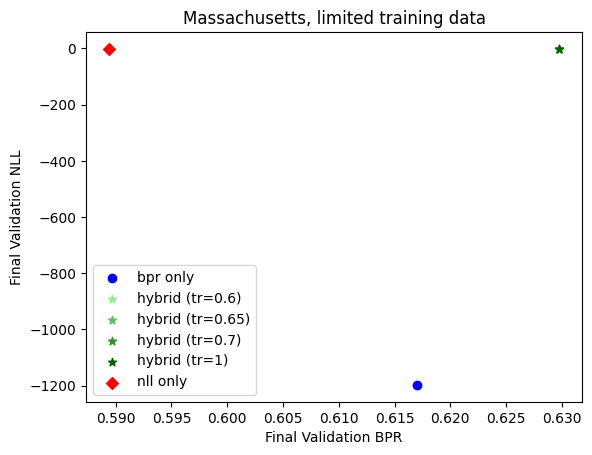

In [14]:
# plot the final val_bpr and -val_nll for all models, use a different color and marker for
# bw = 30, nw=0 call this bpr only
# bw = 30, nw=1 call this hybrid
# bw = 0, nw= call this nll only
# dont do 0 and 0
import matplotlib.colors as mcolors

# Define colors and markers
colors = { (30, 0): 'blue', (30, 1): 'green', (0, 1): 'red' }
markers = { (30, 0): 'o', (30, 1): '*', (0, 1): 'D' }
labels = { (30, 0): 'bpr only', (30, 1): 'hybrid', (0, 1): 'nll only' }

# Generate shades of green for different thresholds
thresholds = sorted(results['tr'].dropna().unique())
shades_of_green = list(mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(np.linspace(0, 1, len(thresholds))))

# Plot data points
for bw, nw in [(30, 0), (30, 1), (0, 1)]:
    mask = (results['bw'] == str(bw)) & (results['nw'] == str(nw))
    if bw == 30 and nw == 0:
        idx = results[mask]['final_val_bpr'].idxmax()
        plt.scatter(results.loc[idx, 'final_val_bpr'], -results.loc[idx, 'final_val_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labels[(bw, nw)])
    elif bw == 30 and nw == 1:
        for i, tr in enumerate(thresholds):
            tr_mask = mask & (results['tr'] == tr)
            idx = results[tr_mask]['final_val_bpr'].idxmax()
            plt.scatter(results.loc[idx, 'final_val_bpr'], -results.loc[idx, 'final_val_nll'], 
                        color=shades_of_green[i], marker=markers[(bw, nw)], label=f"{labels[(bw, nw)]} (tr={tr})")
    elif bw == 0 and nw == 1:
        idx = results[mask]['final_val_bpr'].idxmax()
        plt.scatter(results.loc[idx, 'final_val_bpr'], -results.loc[idx, 'final_val_nll'], 
                    color=colors[(bw, nw)], marker=markers[(bw, nw)], label=labels[(bw, nw)])

# Set labels and legend
plt.title('Massachusetts, limited training data')
plt.xlabel('Final Validation BPR')
plt.ylabel('Final Validation NLL')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(sorted(zip(labels, handles), key=lambda x: x[0]))
plt.legend(by_label.values(), by_label.keys())
plt.show()

